## Práctica de Clasificación Lineal: Regresión Logística

Daniel Garcia Diaz (garciad@ifca.unican.es)

En esta práctica utilizaremos el dataset MNIST, compuesto por 60000 imágenes de train y 10000 imagenes de test (de 28x28 pixeles) correspondientes a distintas versiones digitalizadas de los dígitos 0, ..., 9. 

Descargamos el dataset que vamos a utilizar.

In [ ]:
# Set the directory to be able to read the data properly
# rm(list=ls())
# setwd("")

In [13]:
#Install the necessary packages
install.packages("R.utils")

also installing the dependencies ‘R.oo’, ‘R.methodsS3’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [14]:
# download data from http://yann.lecun.com/exdb/mnist/
download.file("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
              "train-images-idx3-ubyte.gz")
download.file("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
              "train-labels-idx1-ubyte.gz")
download.file("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
              "t10k-images-idx3-ubyte.gz")
download.file("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",
              "t10k-labels-idx1-ubyte.gz")

# gunzip the files
R.utils::gunzip("train-images-idx3-ubyte.gz")
R.utils::gunzip("train-labels-idx1-ubyte.gz")
R.utils::gunzip("t10k-images-idx3-ubyte.gz")
R.utils::gunzip("t10k-labels-idx1-ubyte.gz")

4 archivos diferentes para crear los datasets de train (x_train->train-image e y_train->train-labels) y de test (x->t10k-images e y->t10k-labels).

Funciones para cargar los archivos


In [15]:
# load image files
load_image_file = function(filename) {
  ret = list()
  f = file(filename, 'rb')
  readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  n    = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  nrow = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  ncol = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  x = readBin(f, 'integer', n = n * nrow * ncol, size = 1, signed = FALSE)
  close(f)
  data.frame(matrix(x, ncol = nrow * ncol, byrow = TRUE))
}

# load label files
load_label_file = function(filename) {
  f = file(filename, 'rb')
  readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  n = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  y = readBin(f, 'integer', n = n, size = 1, signed = FALSE)
  close(f)
  y
}

In [16]:
# load images
x_train = load_image_file("train-images-idx3-ubyte")
x_test  = load_image_file("t10k-images-idx3-ubyte")

# load labels
y_train = load_label_file("train-labels-idx1-ubyte")
y_test  = load_label_file("t10k-labels-idx1-ubyte")

Dibujamos los 6 primeros digitos para ver el dataset que tenemos

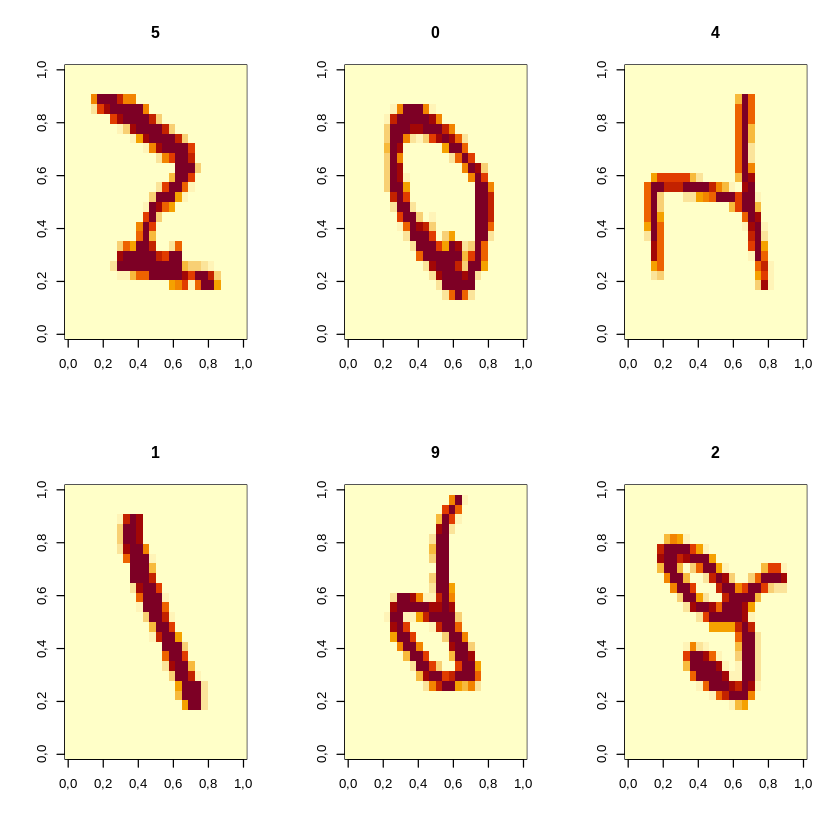

In [31]:
# Dibujamos los 6 primeros dígitos de la base de datos
par(mfrow = c(2,3))
for (i in 1:6) {
    image(matrix(as.matrix(x_train[i,1:784]), nrow = 28, ncol = 28))
    title(y_train[i])
}

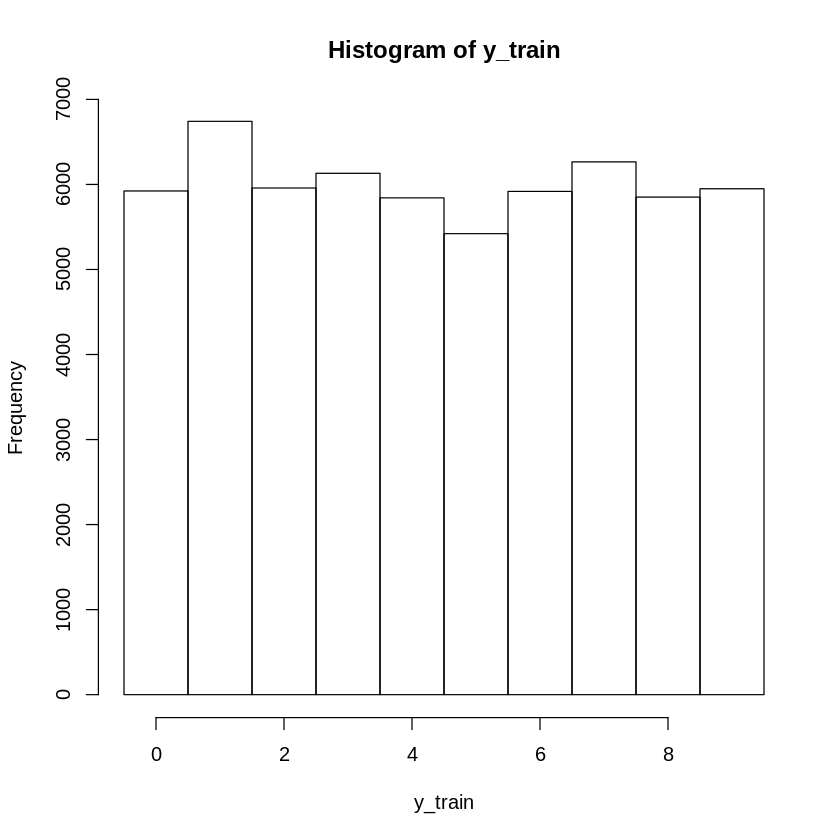

In [32]:
# Cada dígito está igualmente representado en la muestra
hist(y_train, breaks = -0.5:9.5)

El objetivo es clasificar correctamente cada una de las imágenes, utilizando el valor de los 784 pixeles. Este problema se encuandra dentro de la clasificación multi-categoría (tenemos 10 posibles clases a predicir para cada dato). 

Para simplificar estos problemas, se suelen consideran tantos problemas binarios (predecir sí o no) independientes como categorías se tengan. Es decir, un modelo para clasificar 0 (si o no), otro para 1, etc. En este ejemplo, consideramos el dígito '9' y el objetivo es predecir si una imagen es 9 o no.

In [33]:
# Seleccionamos un dígito concreto para tratar de predecirlo. Por ejemplo el nueve
# y9 = 1 si el dígito es 9 y 0 en caso contrario
y9 <- y_train;
y9[which(y_train != 9)] <- 0 ; y9[which(y_train == 9)] <- 1

In [50]:
# Construimos un dataframe para entrenar el modelo
dat <- data.frame(y9,x_train)

Como el tamaño de la muestra es muy grande (60000 imagenes), seleccionamos una muestra para entrenar; por ejemplo, los 5000 primeros dígitos.

In [52]:
i<- 1:5000;
j<-5001:10000
#Random sampling
#i<-sample(1:dim(x)[1],5000);
datT <- dat[i,]
datt <- dat[j,]

Aunque no es el modelo adecuado, ya que no está acotada y puede tomar valores mucho mayores que 1 o menores que 0, construimos primero un modelo de regresión lineal para estos datos.

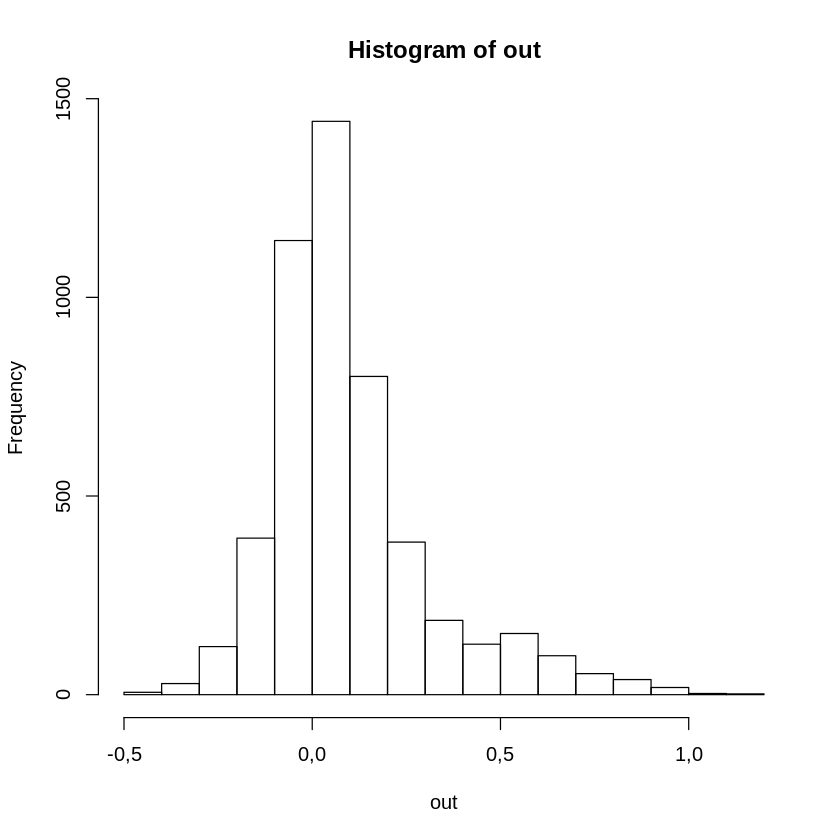

In [36]:
# Entrenamos primero un modelo lineal
model <- lm(datT$y9~., data = datT)
out <- model$fitted.values
# El histograma muestra valores predichos (incluyendo negativos y mayores que 1)
hist(out)

Hacemos la salida del modelo binaria considerando el umbral en 0.5 (a modo de probabilidad) y calculamos la tasa de acierto con los datos de train

In [37]:
# Hacemos binaria la salida considerando el umbral 0.5 (a modo de probabilidad)
outbin <- as.double(out > 0.5)

# Tasa de acierto (en entrenamiento)
100*sum(diag(table(datT[,1], outbin))) / length(outbin)

[1] 96,18

In [38]:
# Tasa de acierto de test
out1<- predict(object=model, newdata = datt);
outbin1 <- as.double(out1 > 0.5)
100*sum(diag(table(datt[,1], outbin1))) / length(outbin1)

Warning message in predict.lm(object = model, newdata = datt):
“prediction from a rank-deficient fit may be misleading”

[1] 94,68

Ahora construimos un modelo de regresión logística utilizando la función 'glm' con la familia 'family = binomial(link = "logit")'

In [39]:
model1 <- glm(datT$y9~., data = datT, family = binomial(link = "logit"))


# Problemas de convergencia con tantas variables
# Coefficients: (138 not defined because of singularities)
# Tasa de acierto (Train)
out2 <- model1$fitted.values
outbin2 <- as.double(out2 > 0.5)
100*sum(diag(table(datT[,1], outbin2))) / length(outbin2)

Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 98,26

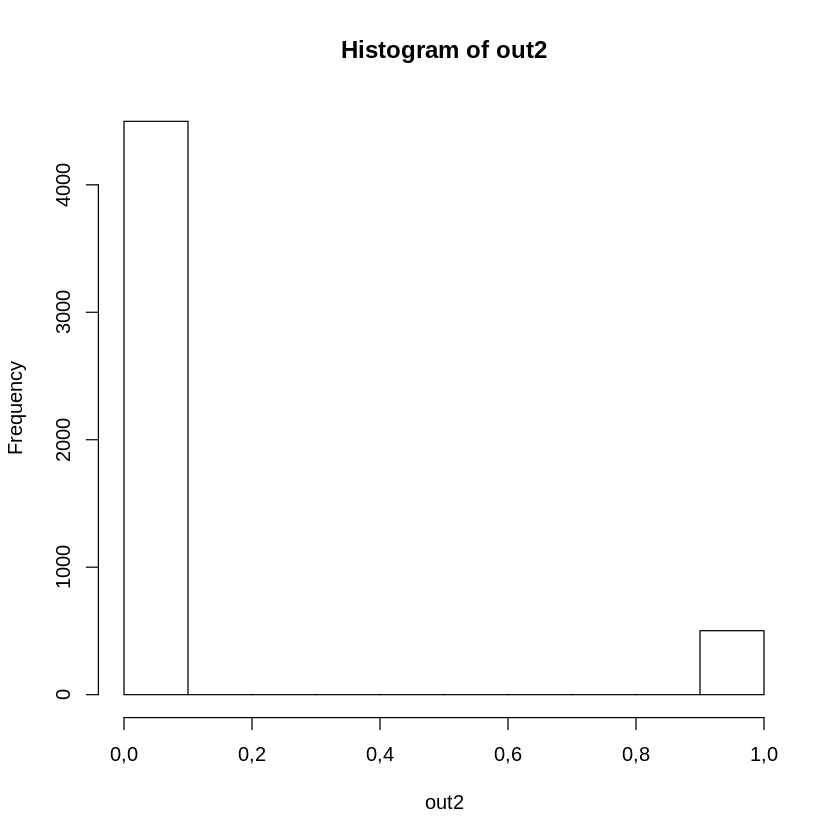

In [40]:
hist(out2)

In [41]:
# Tasa de acierto (test)
out3<- predict(object=model1, newdata = datt);
outbin3 <- as.double(out3 > 0.5)
100*sum(diag(table(datt[,1], outbin3))) / length(outbin3)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”

[1] 92,18

Las inestabilidades numéricas se producen por la alta dimensionalidad de los datos. Algunos de los coeficientes resultan redundantes y el proceso de optimización no converge.
### (195 not defined because of singularities).

Una solución a este problema es reducir la dimensionalidad del conjunto de predictores. Para ello existen técnicas eficientes (como los métodos de regularización o las Componentes Principales) que se verán más adelante. En esta práctica utilizamos un entresacado de información, considerando sólo uno de cada 20 pixeles.

In [42]:
#Modelo de regresión lineal
j<-seq(1,784,20)
model <- lm(datT$y9~., data = datT[,j])
out <- model$fitted.values
outbin <- as.double(out > 0.5)
100*sum(diag(table(datT[,1], outbin))) / length(outbin)
out1<- predict(object=model, newdata = datt[,j]);
outbin1 <- as.double(out1 > 0.5)
100*sum(diag(table(datt[,1], outbin1))) / length(outbin1)

[1] 90,28

Warning message in predict.lm(object = model, newdata = datt[, j]):
“prediction from a rank-deficient fit may be misleading”

[1] 91,1

In [43]:
#Regresión logística
j<-seq(1,784,20)
model <- glm(datT$y9~., data = datT[,j], family = binomial(link = "logit"))
out <- model$fitted.values
outbin <- as.double(out > 0.5)
100*sum(diag(table(datT[,1], outbin))) / length(outbin)
out1<- predict(object=model, newdata = datt[,j]);
outbin1 <- as.double(out1 > 0.5)
100*sum(diag(table(datt[,1], outbin1))) / length(outbin1)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 92,02

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”

[1] 92,26

# PRACTICA 1

Construir un modelo de clasificación para cada dígito, y obtener una ranking de los dígitos en base a su capacidad predictiva (el primero el que mejor se predice, etc.). Para evaluar la capacidad predictiva considerando el error de test obtenido al separar aleatoriamente la muestra en un conjunto de train (n=10000) y el resto de test. 

Nota: usar la función 'sample'. 
Nota2: Elige un entresacado óptimo para que la capacidad predictiva no se reduzca y se reduzca la dimensión el máximo posible.

In [ ]:
# Rellena

## Empiezo por 0

In [106]:
# Train: primeras 5000 imagenes
i <- 1:5000;

# Test: imagenes de 5001 a 10000
j <- 5001:10000

# el numero que quiero esudiar
N = 0

# y_train: sample de train

# añado una columna a la muestra de train, que vale:
# 1 si es el numero que queremo
# 0 si es otro numero

my.y <- y_train;
my.y[which(y_train != N)] <- 0 ; my.y[which(y_train == N)] <- 1

my.dat <- data.frame(my.y,x_train)

my.dat.train <- my.dat[i,]
my.dat.test  <- my.dat[j,]

In [94]:
# entreno el modelo logistico con 5000 imagenes (considero todos los pixeles de la imagen)

my.model <- glm(my.dat.train$my.y~., data = my.dat.train, family = binomial(link = "logit"))

Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

In [102]:
# Tasa de acierto (Train)
out.train <- my.model$fitted.values
out.bin <- as.double(out.train > 0.5)
100*sum(diag(table(my.dat.train[,1], out.bin))) / length(out.bin)

# Matriz de confusion (Train)
table(my.dat.train[,1], out.bin)

[1] 100

   out.bin
       0    1
  0 4521    0
  1    0  479

In [103]:
# Tasa de acierto (test)
out.test<- predict(object=my.model, newdata = my.dat.test);
out.bin.test <- as.double(out.test > 0.5)
100*sum(diag(table(my.dat.test[,1], out.bin.test))) / length(out.bin.test)

# Matriz de confusion (test)
table(my.dat.test[,1], out.bin.test)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”

[1] 96,94

   out.bin.test
       0    1
  0 4365  113
  1   40  482

### Sampleando los pixeles

In [177]:
# Train: primeras 10000 imagenes
i <- 1:10000;

# Test: imagenes de 10001 a 60000
q <- 10001:60000

my.results.vector <-c()

numbers <- seq(0,9)

# el numero que quiero estudiar
for (N in numbers){
    #print(N)

    # y_train: sample de train

    # añado una columna a la muestra de train, que vale:
    # 1 si es el numero que queremo
    # 0 si es otro numero

    my.y <- y_train;
    my.y[which(y_train != N)] <- 0 ; my.y[which(y_train == N)] <- 1

    my.dat <- data.frame(my.y,x_train)

    my.dat.train <- my.dat[i,]
    my.dat.test  <- my.dat[q,]

    # Sample aleatorio de los pixeles que considero
    #j <- sample(0:784, 39)
    j <- seq(1,784,20)

    # Entrenamiento del modelo
    my.model <- glm(my.dat.train$my.y~., data = my.dat.train[,j], family = binomial(link = "logit"))

    # Tasa de acierto (test)
    out.test<- predict(object=my.model, newdata = my.dat.test);
    out.bin.test <- as.double(out.test > 0.5)

    # Guardo la accuracy
    my.results.vector <- c(my.results.vector, 100*sum(diag(table(my.dat.test[,1], out.bin.test))) / length(out.bin.test))
}

names(my.results.vector) <-  numbers
sort.int(my.results.vector, index.return = T)$x

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

PRACTICA 2: Tener en cuenta la variabilidad del error de test a la hora de construir el ranking anterior. Para ello, además de calcular la tasa de acierto para cada dígito, considerar también un "intervalo de confianza" obtenido como la dispersión (desviación típica) de 10 medidas de test obtenidas con 10 muestras aleatorias distintas. ¿Existe algún dígito que pueda predecirse significativamente mejor que los demás?

In [187]:
# Train: primeras 10000 imagenes
i <- 1:10000;

my.results.vector <- c()
my.results.matrix <- matrix(, nrow = 1, ncol = 0)

numbers <- seq(0,9)

# el numero que quiero estudiar
for (N in numbers){
    #print(N)

    # y_train: sample de train

    # añado una columna a la muestra de train, que vale:
    # 1 si es el numero que queremo
    # 0 si es otro numero

    my.y <- y_train;
    my.y[which(y_train != N)] <- 0 ; my.y[which(y_train == N)] <- 1

    my.dat <- data.frame(my.y,x_train)

    my.dat.train <- my.dat[i,]

    # Sample aleatorio de los pixeles que considero
    #j <- sample(0:784, 39)
    j <- seq(1,784,20)

    # Entrenamiento del modelo
    my.model <- glm(my.dat.train$my.y~., data = my.dat.train[,j], family = binomial(link = "logit"))

    # test (repetido 10 veces)
    for (z in 1:10){
    
        # Test: 5000 imagenes aleatorias
        q <- sample(10001:60000, 5000)
        my.dat.test  <- my.dat[q,]

        # Tasa de acierto (test)
        out.test<- predict(object=my.model, newdata = my.dat.test);
        out.bin.test <- as.double(out.test > 0.5)

        #print(100*sum(diag(table(my.dat.test[,1], out.bin.test))) / length(out.bin.test))
        
        # Guardo la accuracy
        my.results.vector <- c(my.results.vector, 100*sum(diag(table(my.dat.test[,1], out.bin.test))) / length(out.bin.test))
    }
}

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, 

“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning me

"96,18","95,98","94,28","93,14","93,14","92,16","93,08","95,20","92,82","90,92"
"96,42","96,02","94,40","92,16","93,24","92,06","92,94","94,70","93,12","91,44"
"96,42","95,70","94,76","92,50","93,68","92,78","93,16","95,00","92,38","91,50"
"96,06","95,78","94,44","92,54","93,46","92,38","93,42","95,06","92,44","91,78"
"96,20","96,18","93,72","92,46","93,38","92,02","93,30","94,72","92,40","91,32"
"96,16","95,90","94,04","92,36","93,44","91,84","93,90","94,34","92,20","91,94"
"96,12","96,38","93,90","92,26","93,84","92,50","93,58","94,82","92,64","91,36"
"96,18","96,46","94,88","92,16","93,48","92,84","93,22","95,06","92,72","91,54"
"95,80","96,18","94,30","92,34","93,38","92,46","92,92","94,58","91,92","91,50"
"95,90","96,18","94,38","92,20","93,46","92,96","93,40","94,60","92,02","91,22"


[1] 96,18 96,42 96,42 96,06 96,20 96,16 96,12 96,18 95,80 95,90 95,98 96,02
 [13] 95,70 95,78 96,18 95,90 96,38 96,46 96,18 96,18 94,28 94,40 94,76 94,44
 [25] 93,72 94,04 93,90 94,88 94,30 94,38 93,14 92,16 92,50 92,54 92,46 92,36
 [37] 92,26 92,16 92,34 92,20 93,14 93,24 93,68 93,46 93,38 93,44 93,84 93,48
 [49] 93,38 93,46 92,16 92,06 92,78 92,38 92,02 91,84 92,50 92,84 92,46 92,96
 [61] 93,08 92,94 93,16 93,42 93,30 93,90 93,58 93,22 92,92 93,40 95,20 94,70
 [73] 95,00 95,06 94,72 94,34 94,82 95,06 94,58 94,60 92,82 93,12 92,38 92,44
 [85] 92,40 92,20 92,64 92,72 91,92 92,02 90,92 91,44 91,50 91,78 91,32 91,94
 [97] 91,36 91,54 91,50 91,22

In [196]:
my.results.vector <- matrix(my.results.vector, nrow = 10, ncol = 10)

#my.results.vector

my.mean.values <- apply(my.results.vector, FUN = mean, MARGIN = 2)
my.mean.values

my.vars <- apply(my.results.vector, FUN = var, MARGIN = 2)
my.vars

[1] 96,144 96,076 94,310 92,412 93,450 92,400 93,292 94,808 92,466 91,452

[1] 0,03820444 0,06051556 0,12748889 0,08437333 0,03957778 0,14408889
 [7] 0,09006222 0,07237333 0,13644889 0,08010667

TRABAJO EXTRA: Hasta ahora hemos utilizado la tasa de acierto como medida de validación de los clasificadores. Para ello, las predicciones probabilísticas se tiene que convertir a binarias (utilizando un umbral para al probabilidad). Sin embargo, existen otras medidas más generales que consideran el carácter probabilístico de la predicción. 
Leer https://es.wikipedia.org/wiki/Curva_ROC
Practicar con el paquete 'AUC'
#install.packages("AUC")
#library("AUC")
#roc<-roc(out,as.factor(datT[,1]))
#auc(roc)
#plot(roc)